In [ ]:
!pip install -qU openimages torch_snippets

In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
!pip install pyyaml==5.1 pycocotools>=2.0.1

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html


In [ ]:
from torch_snippets import *
!wget -O train-annotations-object-segmentation.csv -q https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv
!wget -O classes.csv -q https://raw.githubusercontent.com/openimages/dataset/master/dict.csv

In [ ]:
required_classes = 'person,dog,bird,ambulance,sky'
required_classes = [c.lower() for c in required_classes.lower().split(',')]
print(required_classes)

['person', 'dog', 'bird', 'ambulance', 'sky']


In [ ]:
classes = pd.read_csv('classes.csv', header=None)
classes.columns = ['class','class_name']
classes = classes[classes['class_name'].map(lambda x: x in required_classes)]
classes.head(10)


,class,class_name
76,/m/012n7d,ambulance
224,/m/015p6,bird
570,/m/01bqvp,sky
753,/m/01g317,person
6420,/m/0bt9lr,dog


In [ ]:
dataset = pd.read_csv('train-annotations-object-segmentation.csv')
dataset.head()

,MaskPath,ImageID,LabelName,BoxID,BoxXMin,BoxXMax,BoxYMin,BoxYMax,PredictedIoU,Clicks
0,677c122b0eaa5d16_m04yx4_9a041d52.png,677c122b0eaa5d16,/m/04yx4,9a041d52,0.887500,0.960938,0.454167,0.720833,0.86864,0.95498 0.65197 1;0.89370 0.56579 1;0.94701 0....
1,05529ae018130c68_m09j2d_b1115fd0.png,05529ae018130c68,/m/09j2d,b1115fd0,0.086875,0.254375,0.504708,0.790960,0.80250,0.16388 0.50114 1;0.25069 0.75425 1;0.13478 0....
2,96e7ee70b428a54e_m04yx4_05580497.png,96e7ee70b428a54e,/m/04yx4,05580497,0.456250,0.603125,0.222013,0.903104,0.55850,0.52271 0.46625 0;0.52695 0.70150 0;0.59151 0....
3,76084f166740d78a_m09j2d_557dfcf5.png,76084f166740d78a,/m/09j2d,557dfcf5,0.018750,0.145625,0.313333,0.754167,0.62394,0.08756 0.34082 0;0.03971 0.34195 1;0.06705 0....
4,ebaccfc70c721055_m02p0tk3_b39109c0.png,ebaccfc70c721055,/m/02p0tk3,b39109c0,0.097500,0.212500,0.291667,0.930833,0.84223,0.19847 0.85413 1;0.18916 0.34751 1;0.18636 0....


In [ ]:
data = pd.merge(dataset, classes, left_on='LabelName', right_on='class')
data.head(3)

,MaskPath,ImageID,LabelName,BoxID,BoxXMin,BoxXMax,BoxYMin,BoxYMax,PredictedIoU,Clicks,class,class_name
0,e9a7da5ff1fd56df_m01g317_1803811b.png,e9a7da5ff1fd56df,/m/01g317,1803811b,0.468125,0.628750,0.188714,0.949121,0.86841,0.47513 0.38255 1;0.52118 0.91333 0;0.47513 0....,/m/01g317,person
1,18c1fd8342d55af8_m01g317_a9a97702.png,18c1fd8342d55af8,/m/01g317,a9a97702,0.394375,0.605000,0.241667,0.903333,0.81242,0.57036 0.81358 1;0.54599 0.65655 0;0.42280 0....,/m/01g317,person
2,42ea7facefea9a28_m01g317_333376e6.png,42ea7facefea9a28,/m/01g317,333376e6,0.791875,0.839375,0.096226,0.184906,0.64984,0.79876 0.17372 1;0.84756 0.19868 1;0.80936 0....,/m/01g317,person


In [ ]:
subset_data = data.groupby('class_name').agg({'ImageID': lambda x: list(x)[:500]})
subset_data = flatten(subset_data.ImageID.tolist())
subset_data = data[data['ImageID'].map(lambda x: x in subset_data)]
subset_masks = subset_data['MaskPath'].tolist()

In [ ]:
subset_data.head(3)

,MaskPath,ImageID,LabelName,BoxID,BoxXMin,BoxXMax,BoxYMin,BoxYMax,PredictedIoU,Clicks,class,class_name
0,e9a7da5ff1fd56df_m01g317_1803811b.png,e9a7da5ff1fd56df,/m/01g317,1803811b,0.468125,0.628750,0.188714,0.949121,0.86841,0.47513 0.38255 1;0.52118 0.91333 0;0.47513 0....,/m/01g317,person
1,18c1fd8342d55af8_m01g317_a9a97702.png,18c1fd8342d55af8,/m/01g317,a9a97702,0.394375,0.605000,0.241667,0.903333,0.81242,0.57036 0.81358 1;0.54599 0.65655 0;0.42280 0....,/m/01g317,person
2,42ea7facefea9a28_m01g317_333376e6.png,42ea7facefea9a28,/m/01g317,333376e6,0.791875,0.839375,0.096226,0.184906,0.64984,0.79876 0.17372 1;0.84756 0.19868 1;0.80936 0....,/m/01g317,person


In [ ]:
subset_masks

['e9a7da5ff1fd56df_m01g317_1803811b.png',
 '18c1fd8342d55af8_m01g317_a9a97702.png',
 '42ea7facefea9a28_m01g317_333376e6.png',
 'bcb123bf7f256b1c_m01g317_a42b01bc.png',
 'a2bb5944e071223c_m01g317_7ef4ab8d.png',
 '4fd2304f1f65dc74_m01g317_336e67e1.png',
 '0113dbe2b087bd55_m01g317_d606a644.png',
 'cc8c1cec5a263473_m01g317_5dd13cd7.png',
 'd6dc04e65df11e78_m01g317_cfc9e8e5.png',
 'db35878a7d398f65_m01g317_d61cc87b.png',
 'cc7d86be6c6e24a6_m01g317_fab50e83.png',
 '14c8a499020caade_m01g317_e6c9a372.png',
 'c74dbf9e68d22a45_m01g317_67ae119d.png',
 '58bef7a01e2dff7f_m01g317_4e59f931.png',
 '6f43ffcdbae07693_m01g317_14dcf480.png',
 '80dc55d1800ba6fa_m01g317_27f66e58.png',
 '29e4434b9a15536e_m01g317_654108f5.png',
 '9124b017e64376a2_m01g317_8b1c0c67.png',
 'ff4de245985c0e8e_m01g317_feced4c1.png',
 'eba59e5538fd6de6_m01g317_010e20d4.png',
 '44e5e820a7d288c1_m01g317_32a4cc26.png',
 '1e8f8fdbf4a0eb81_m01g317_268b63c5.png',
 '2dfb379a08227177_m01g317_5aea1ffa.png',
 '3c639ae1d1446746_m01g317_1c8dee4

In [ ]:
!mkdir -p masks
for c in Tqdm('0123456789abcdef'):
    !wget -q https://storage.googleapis.com/openimages/v5/train-masks/train-masks-{c}.zip
    !unzip -q train-masks-{c}.zip -d tmp_masks
    !rm train-masks-{c}.zip
    tmp_masks = Glob('tmp_masks', silent=True)
    items = [(m,fname(m)) for m in tmp_masks]
    items = [(i,j) for (i,j) in items if j in subset_masks]
    for i,j in items:
        os.rename(i, f'masks/{j}')
    !rm -rf tmp_masks

100%|██████████| 16/16 [16:31<00:00, 61.95s/it]


In [ ]:
masks = Glob('masks')
masks = [fname(mask) for mask in masks]
subset_data = subset_data[subset_data['MaskPath'].map(lambda \
x: x in masks)]
subset_imageIds = subset_data['ImageID'].tolist()
from openimages.download import _download_images_by_id
!mkdir images
_download_images_by_id(subset_imageIds, 'train', './images/')

2021-10-19 07:58:20.760 | INFO     | torch_snippets.paths:inner:24 - 4880 files found at masks
100%|██████████| 4880/4880 [01:04<00:00, 75.84it/s]


In [ ]:
import zipfile
files = Glob('images') + Glob('masks') + ['train-annotations-object-segmentation.csv', 'classes.csv']
with zipfile.ZipFile('data.zip','w') as zipme:
    for file in Tqdm(files):
        zipme.write(file, compress_type=zipfile.ZIP_DEFLATED)

2021-10-19 07:59:26.442 | INFO     | torch_snippets.paths:inner:24 - 1792 files found at images
2021-10-19 07:59:26.472 | INFO     | torch_snippets.paths:inner:24 - 4880 files found at masks
100%|██████████| 6674/6674 [01:37<00:00, 68.55it/s]


In [ ]:
!mkdir -p train/
!mv images train/myData2020
!mv masks train/annotations

In [ ]:
!pip install git+git://github.com/waspinator/pycococreator.git@0.2.0
import datetime

INFO = {
    "description": "MyData2021",
    "url": "None",
    "version": "1.0",
    "year": 2021,
    "contributor": "rishika",
    "date_created": datetime.datetime.utcnow().isoformat(' ')
}

LICENSES = [
    {
        "id": 1,
        "name": "MIT"
    }
]

  Cloning git://github.com/waspinator/pycococreator.git (to revision 0.2.0) to /tmp/pip-req-build-whsvba0s
  Running command git clone -q git://github.com/waspinator/pycococreator.git /tmp/pip-req-build-whsvba0s
  Running command git checkout -q fba8f4098f3c7aaa05fe119dc93bbe4063afdab8
  Created wheel for pycococreatortools: filename=pycococreatortools-0.2.0-py3-none-any.whl size=7203 sha256=06763050891b4301816dd3b09c87090fe5a990874c8a0544c3544f3110636b5a
  Stored in directory: /tmp/pip-ephem-wheel-cache-7eti_jcb/wheels/dd/2d/45/7de22caaf80e3e5c6a654d4e504e98578a12c74b057e584bfe
Successfully built pycococreatortools


In [ ]:
CATEGORIES = [{'id': id+1, 'name': name.replace('/',''), 'supercategory': 'none'} for id,(_,(name, clss_name)) in enumerate(classes.iterrows())]

In [ ]:
!pip install pycocotools
from pycococreatortools import pycococreatortools
from os import listdir
from os.path import isfile, join
from PIL import Image

coco_output = {
    "info": INFO,
    "licenses": LICENSES,
    "categories": CATEGORIES,
    "images": [],
    "annotations": []
}

In [ ]:
ROOT_DIR = "train"
IMAGE_DIR, ANNOTATION_DIR = 'train/myData2020/', 'train/annotations/'
image_files = [f for f in listdir(IMAGE_DIR) if isfile(join(IMAGE_DIR, f))]
annotation_files = [f for f in listdir(ANNOTATION_DIR) if isfile(join(ANNOTATION_DIR, f))]

In [ ]:
image_id = 1
for image_filename in Tqdm(image_files):
    image = Image.open(IMAGE_DIR + '/' + image_filename)
    image_info = pycococreatortools.create_image_info(image_id, os.path.basename(image_filename), image.size)
    coco_output["images"].append(image_info)
    image_id = image_id + 1

100%|██████████| 1792/1792 [00:00<00:00, 7044.09it/s]


In [ ]:
segmentation_id = 1
for annotation_filename in Tqdm(annotation_files):
    image_id = [f for f in coco_output['images'] if stem(f['file_name'])==annotation_filename.split('_')[0]][0]['id']
    class_id = [x['id'] for x in CATEGORIES if x['name'] in annotation_filename][0]
    category_info = {'id': class_id, 'is_crowd': 'crowd' in image_filename}
    binary_mask = np.asarray(Image.open(f'{ANNOTATION_DIR}/{annotation_filename}').convert('1')).astype(np.uint8)
 
    annotation_info = pycococreatortools.create_annotation_info(segmentation_id, image_id, category_info, binary_mask, image.size, tolerance=2)

    if annotation_info is not None:
        coco_output["annotations"].append(annotation_info)
        segmentation_id = segmentation_id + 1

100%|██████████| 4880/4880 [05:09<00:00, 15.79it/s]


In [ ]:
coco_output['categories'] = [{'id': id+1, 'name': clss_name, 'supercategory': 'none'} for id,(_,(name, clss_name)) in enumerate(classes.iterrows())]

import json
with open('images.json', 'w') as output_json_file:
    json.dump(coco_output, output_json_file)

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("dataset_train", {}, "images.json", "train/myData2020")

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") # pretrained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025 # pick a good LR
cfg.SOLVER.MAX_ITER = 2800 # instead of epochs, we train on 5000 batches
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

2021-10-19  08:08:16 INFO Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequent

In [ ]:
!cp output/model_final.pth output/trained_model.pth

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/output/trained_model.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25
predictor = DefaultPredictor(cfg)

2021-10-19  09:34:02 INFO [Checkpointer] Loading from /content/output/trained_model.pth ...


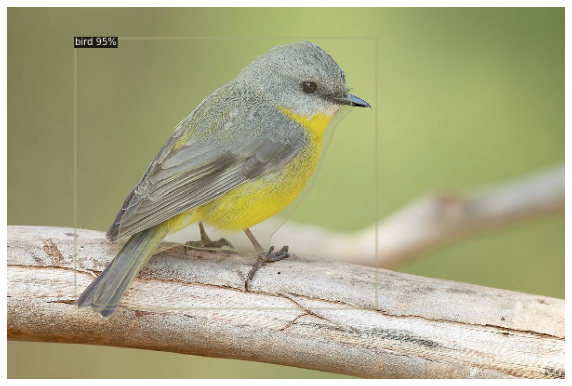

In [ ]:
from detectron2.utils.visualizer import ColorMode
img=cv2.imread('/content/WhatsApp Image 2021-10-19 at 12.39.53 PM.jpeg')
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1], scale=0.5, metadata=MetadataCatalog.get("dataset_train"), instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show(out.get_image(), sz=10)

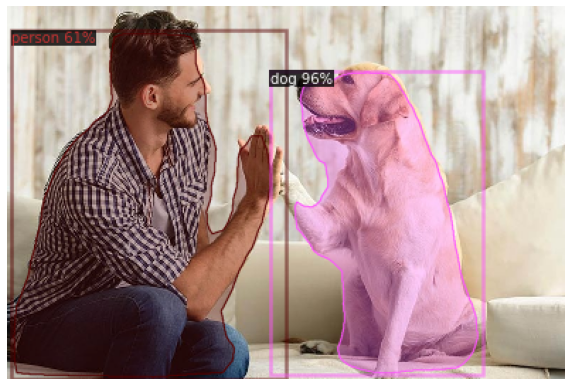

In [ ]:
img=cv2.imread('/content/Human,Bird.jpeg')
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1], scale=0.5, metadata=MetadataCatalog.get("dataset_train"), instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show(out.get_image(), sz=10)

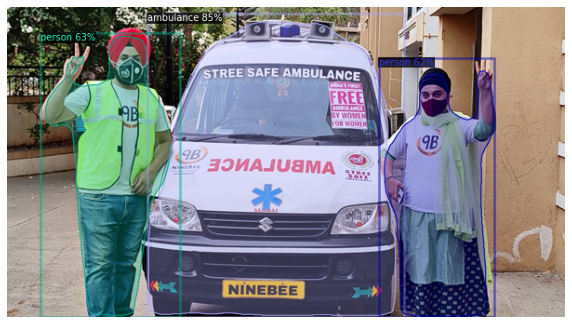

In [ ]:
img=cv2.imread('/content/pic.jpg')
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1], scale=0.5, metadata=MetadataCatalog.get("dataset_train"), instance_mode=ColorMode.IMAGE_BW)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show(out.get_image(), sz=10)